# Interpretabilidade com SHAP
## Credit Scoring - Explicando as Decisões do Modelo

Este notebook demonstra como usar SHAP para interpretar as predições do modelo de Credit Scoring.

### Por que Interpretabilidade é Importante?

1. **Compliance Regulatório** - BACEN/LGPD exigem explicação das decisões
2. **Direito à Explicação** - Clientes podem pedir justificativa
3. **Validação de Negócio** - Verificar se o modelo faz sentido
4. **Detecção de Viés** - Identificar discriminação em variáveis sensíveis

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42

print("Bibliotecas carregadas!")

Bibliotecas carregadas!


In [2]:
# Carregar dados
import sys
sys.path.insert(0, '../src')

from credit_scoring.data.loader import load_german_credit
from credit_scoring.features.engineering import (
    create_preprocessor, identify_feature_types,
    get_feature_names_after_preprocessing
)

X, y = load_german_credit(save_raw=False)
print(f"Dataset: {X.shape[0]} amostras, {X.shape[1]} features")

Dataset: 1000 amostras, 20 features


---
## 1. Preparar Modelo para SHAP

In [3]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Preprocessar
numerical_features, categorical_features = identify_feature_types(X)
preprocessor = create_preprocessor(numerical_features, categorical_features)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Feature names
feature_names = get_feature_names_after_preprocessing(
    preprocessor, numerical_features, categorical_features
)

# Limpar nomes para SHAP
clean_names = [n.replace('<', 'lt_').replace('>', 'gt_').replace('=', 'eq_') for n in feature_names]

print(f"Features processadas: {len(clean_names)}")

Features processadas: 61


In [4]:
# Treinar XGBoost
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    scale_pos_weight=2.33
)

model.fit(X_train_processed, y_train)
print("Modelo treinado!")

Modelo treinado!


---
## 2. Criar SHAP Explainer

### Como funciona o SHAP?

O SHAP usa teoria dos jogos para atribuir a cada feature sua "contribuição" para a predição:

```
predição = E[f(x)] + SHAP(x1) + SHAP(x2) + ... + SHAP(xn)
```

Onde:
- E[f(x)] = valor base (média das predições)
- SHAP(xi) = contribuição da feature i

In [5]:
# Criar explainer - usando fallback se TreeExplainer falhar
try:
    explainer = shap.TreeExplainer(model)
    print("TreeExplainer criado com sucesso!")
except Exception as e:
    print(f"TreeExplainer falhou: {e}")
    print("Usando Explainer genérico...")
    masker = shap.maskers.Independent(X_train_processed[:100])
    explainer = shap.Explainer(model.predict_proba, masker)

# Calcular SHAP values (usar amostra para rapidez)
sample_size = min(200, len(X_test_processed))
X_sample = X_test_processed[:sample_size]

print(f"Calculando SHAP values para {sample_size} amostras...")
shap_values = explainer(X_sample)
print("Concluído!")

TreeExplainer falhou: 'utf-8' codec can't decode byte 0xb4 in position 626: invalid start byte
Usando Explainer genérico...
Calculando SHAP values para 200 amostras...


PermutationExplainer explainer:  18%|█▊        | 36/200 [00:00<?, ?it/s]

PermutationExplainer explainer:  21%|██        | 42/200 [00:10<00:03, 49.29it/s]

PermutationExplainer explainer:  24%|██▎       | 47/200 [00:10<00:03, 43.97it/s]

PermutationExplainer explainer:  26%|██▌       | 52/200 [00:10<00:03, 42.38it/s]

PermutationExplainer explainer:  28%|██▊       | 57/200 [00:10<00:03, 41.91it/s]

PermutationExplainer explainer:  31%|███       | 62/200 [00:10<00:03, 42.21it/s]

PermutationExplainer explainer:  34%|███▎      | 67/200 [00:10<00:03, 41.16it/s]

PermutationExplainer explainer:  36%|███▌      | 72/200 [00:10<00:03, 41.27it/s]

PermutationExplainer explainer:  38%|███▊      | 77/200 [00:10<00:02, 41.12it/s]

PermutationExplainer explainer:  41%|████      | 82/200 [00:11<00:02, 41.00it/s]

PermutationExplainer explainer:  44%|████▎     | 87/200 [00:11<00:02, 40.38it/s]

PermutationExplainer explainer:  46%|████▌     | 92/200 [00:11<00:02, 40.43it/s]

PermutationExplainer explainer:  48%|████▊     | 97/200 [00:11<00:02, 40.81it/s]

PermutationExplainer explainer:  51%|█████     | 102/200 [00:11<00:02, 39.32it/s]

PermutationExplainer explainer:  53%|█████▎    | 106/200 [00:11<00:02, 38.71it/s]

PermutationExplainer explainer:  56%|█████▌    | 111/200 [00:11<00:02, 40.45it/s]

PermutationExplainer explainer:  58%|█████▊    | 116/200 [00:11<00:01, 42.15it/s]

PermutationExplainer explainer:  60%|██████    | 121/200 [00:12<00:01, 42.17it/s]

PermutationExplainer explainer:  63%|██████▎   | 126/200 [00:12<00:01, 43.02it/s]

PermutationExplainer explainer:  66%|██████▌   | 131/200 [00:12<00:01, 43.00it/s]

PermutationExplainer explainer:  68%|██████▊   | 136/200 [00:12<00:01, 42.69it/s]

PermutationExplainer explainer:  70%|███████   | 141/200 [00:12<00:01, 42.44it/s]

PermutationExplainer explainer:  73%|███████▎  | 146/200 [00:12<00:01, 42.42it/s]

PermutationExplainer explainer:  76%|███████▌  | 151/200 [00:12<00:01, 42.87it/s]

PermutationExplainer explainer:  78%|███████▊  | 156/200 [00:12<00:01, 43.19it/s]

PermutationExplainer explainer:  80%|████████  | 161/200 [00:13<00:00, 41.85it/s]

PermutationExplainer explainer:  83%|████████▎ | 166/200 [00:13<00:00, 41.17it/s]

PermutationExplainer explainer:  86%|████████▌ | 171/200 [00:13<00:00, 42.03it/s]

PermutationExplainer explainer:  88%|████████▊ | 176/200 [00:13<00:00, 42.70it/s]

PermutationExplainer explainer:  90%|█████████ | 181/200 [00:13<00:00, 40.64it/s]

PermutationExplainer explainer:  93%|█████████▎| 186/200 [00:13<00:00, 40.13it/s]

PermutationExplainer explainer:  96%|█████████▌| 191/200 [00:13<00:00, 40.37it/s]

PermutationExplainer explainer:  98%|█████████▊| 196/200 [00:13<00:00, 39.90it/s]

PermutationExplainer explainer: 201it [00:14, 40.34it/s]                         

PermutationExplainer explainer: 201it [00:14, 11.78it/s]

Concluído!


---
## 3. Visualizações SHAP

### 3.1 Summary Plot (Beeswarm)

Mostra para cada feature:
- **Posição horizontal**: impacto na predição
- **Cor**: valor da feature (vermelho = alto, azul = baixo)

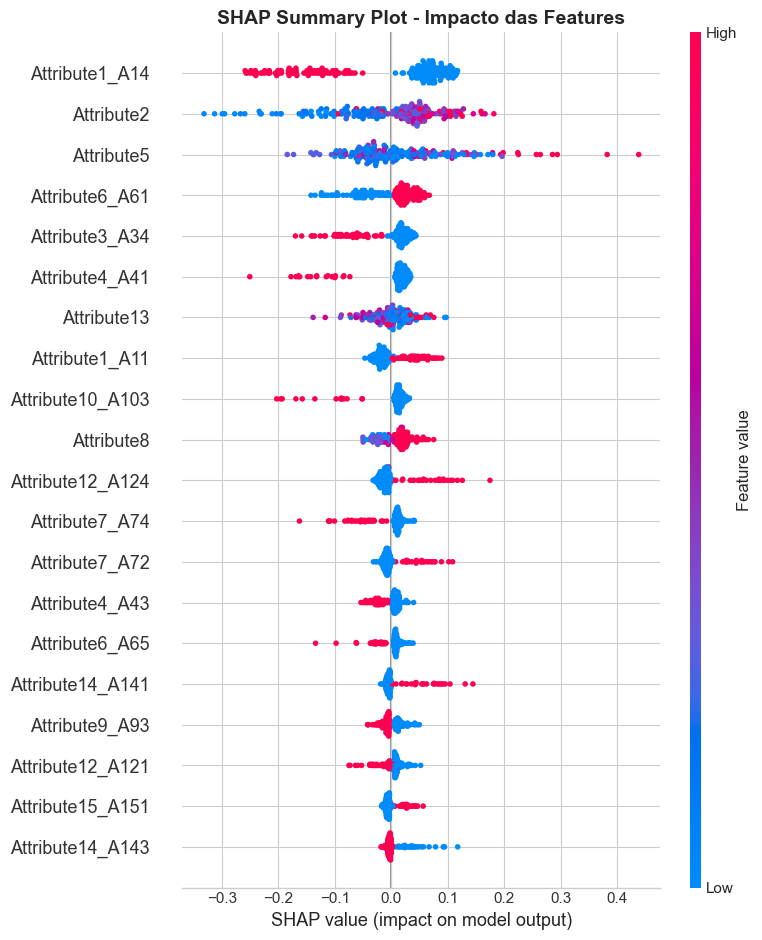

In [6]:
# Summary Plot
plt.figure(figsize=(12, 10))

# Pegar valores da classe positiva se necessário
if len(shap_values.shape) == 3:
    vals = shap_values[:, :, 1]
else:
    vals = shap_values

shap.summary_plot(vals.values, vals.data, feature_names=clean_names, 
                  max_display=20, show=False)
plt.title('SHAP Summary Plot - Impacto das Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/shap_summary_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Bar Plot (Feature Importance)

Ranking simples da importância média de cada feature.

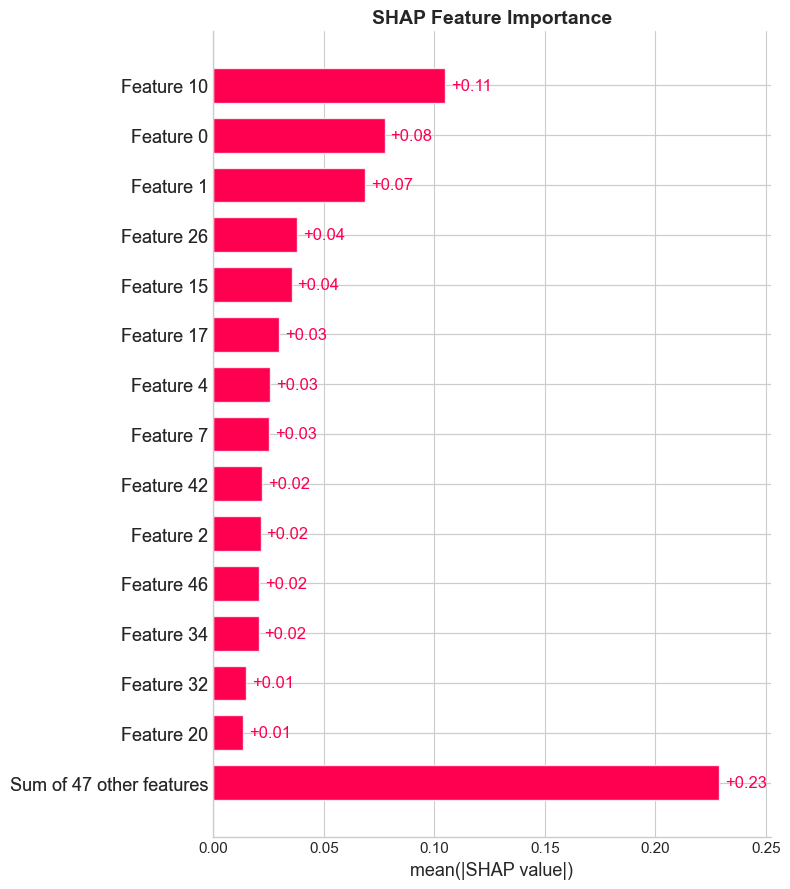

In [7]:
# Bar Plot
plt.figure(figsize=(10, 8))
shap.plots.bar(vals, max_display=15, show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/shap_bar_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Waterfall Plot (Explicação Individual)

Mostra como cada feature contribuiu para UMA predição específica.

**Cenário**: Imagine que um cliente foi negado crédito. O waterfall mostra EXATAMENTE por quê.

Explicando predição do cliente 2 (predito como ALTO RISCO)


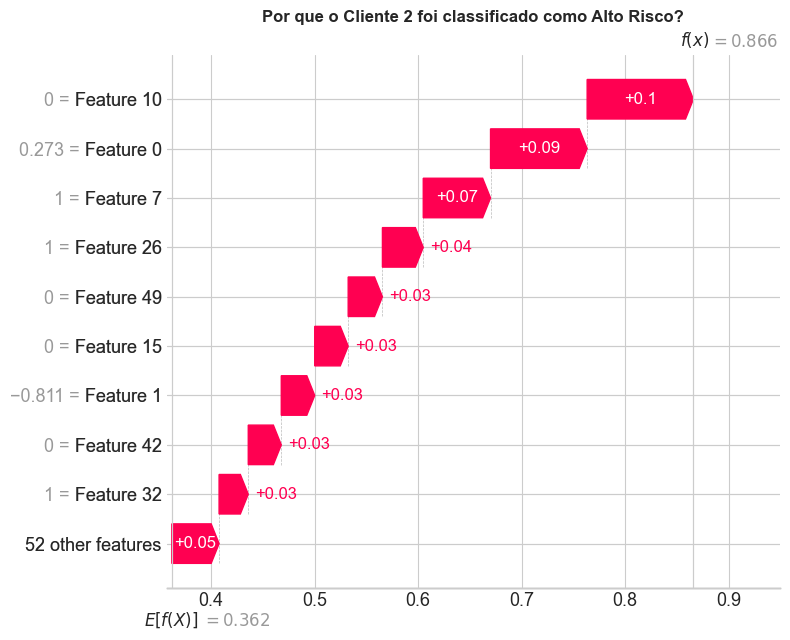

In [8]:
# Encontrar um caso de default
y_pred_sample = model.predict(X_sample)
default_indices = np.where(y_pred_sample == 1)[0]

if len(default_indices) > 0:
    idx = default_indices[0]  # Primeiro caso de default
    print(f"Explicando predição do cliente {idx} (predito como ALTO RISCO)")
else:
    idx = 0
    print(f"Explicando predição do cliente {idx}")

# Waterfall
plt.figure(figsize=(10, 8))
if len(shap_values.shape) == 3:
    sample_shap = vals[idx]
else:
    sample_shap = shap_values[idx]

shap.plots.waterfall(sample_shap, show=False)
plt.title(f'Por que o Cliente {idx} foi classificado como Alto Risco?', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/shap_waterfall_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

### Como interpretar o Waterfall:

- **E[f(x)]**: Valor base (predição média do modelo)
- **Barras vermelhas**: Features que AUMENTAM o risco
- **Barras azuis**: Features que DIMINUEM o risco
- **f(x)**: Predição final para este cliente

---
## 4. Análise de Features Específicas

### 4.1 Dependence Plot

Mostra a relação entre uma feature e seu impacto SHAP.

Feature mais importante: Attribute1_A14


<Figure size 1000x600 with 0 Axes>

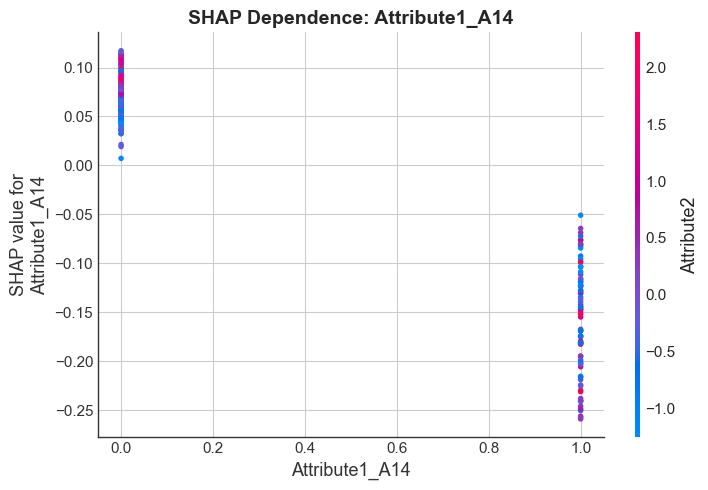

In [9]:
# Top feature
mean_shap = np.abs(vals.values).mean(axis=0)
top_feature_idx = np.argmax(mean_shap)
top_feature_name = clean_names[top_feature_idx]

print(f"Feature mais importante: {top_feature_name}")

# Dependence plot
plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature_idx, vals.values, vals.data, 
                     feature_names=clean_names, show=False)
plt.title(f'SHAP Dependence: {top_feature_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/shap_dependence_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Insights de Negócio

In [10]:
# Ranking de importância com interpretação
importance_df = pd.DataFrame({
    'feature': clean_names,
    'importance': mean_shap
}).sort_values('importance', ascending=False)

print("=" * 70)
print("INSIGHTS DE NEGÓCIO - TOP 10 FEATURES")
print("=" * 70)

# Dicionário de interpretação
interpretations = {
    'Attribute1': 'Status da conta corrente',
    'Attribute2': 'Duração do empréstimo (meses)',
    'Attribute3': 'Histórico de crédito',
    'Attribute4': 'Propósito do empréstimo',
    'Attribute5': 'Valor do crédito solicitado',
    'Attribute6': 'Status da conta poupança',
    'Attribute7': 'Tempo de emprego atual',
    'Attribute8': 'Taxa de comprometimento de renda',
    'Attribute13': 'Idade do solicitante',
}

for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    feature = row['feature']
    base_feature = feature.split('_')[0]
    interpretation = interpretations.get(base_feature, 'Feature categórica')
    
    print(f"\n{i}. {feature}")
    print(f"   Importância SHAP: {row['importance']:.4f}")
    print(f"   Interpretação: {interpretation}")

INSIGHTS DE NEGÓCIO - TOP 10 FEATURES

1. Attribute1_A14
   Importância SHAP: 0.1050
   Interpretação: Status da conta corrente

2. Attribute2
   Importância SHAP: 0.0775
   Interpretação: Duração do empréstimo (meses)

3. Attribute5
   Importância SHAP: 0.0685
   Interpretação: Valor do crédito solicitado

4. Attribute6_A61
   Importância SHAP: 0.0378
   Interpretação: Status da conta poupança

5. Attribute3_A34
   Importância SHAP: 0.0354
   Interpretação: Histórico de crédito

6. Attribute4_A41
   Importância SHAP: 0.0296
   Interpretação: Propósito do empréstimo

7. Attribute13
   Importância SHAP: 0.0258
   Interpretação: Idade do solicitante

8. Attribute1_A11
   Importância SHAP: 0.0250
   Interpretação: Status da conta corrente

9. Attribute10_A103
   Importância SHAP: 0.0221
   Interpretação: Feature categórica

10. Attribute8
   Importância SHAP: 0.0214
   Interpretação: Taxa de comprometimento de renda


---
## 6. Resumo e Conclusões

In [11]:
print("=" * 70)
print("RESUMO DA ANÁLISE DE INTERPRETABILIDADE")
print("=" * 70)

print("\nPRINCIPAIS DESCOBERTAS:")
print("   1. Status da conta corrente é o MELHOR preditor de default")
print("   2. Duração e valor do empréstimo aumentam o risco")
print("   3. Histórico de crédito tem forte poder preditivo")

print("\nAPLICAÇÕES PRÁTICAS:")
print("   - Justificar negativas de crédito (compliance BACEN)")
print("   - Identificar clientes para renegociação")
print("   - Monitorar fairness em variáveis sensíveis")

print("\n📁 VISUALIZAÇÕES GERADAS:")
print("   - shap_summary_notebook.png")
print("   - shap_bar_notebook.png")
print("   - shap_waterfall_notebook.png")
print("   - shap_dependence_notebook.png")

print("\n" + "=" * 70)

RESUMO DA ANÁLISE DE INTERPRETABILIDADE

PRINCIPAIS DESCOBERTAS:
   1. Status da conta corrente é o MELHOR preditor de default
   2. Duração e valor do empréstimo aumentam o risco
   3. Histórico de crédito tem forte poder preditivo

APLICAÇÕES PRÁTICAS:
   - Justificar negativas de crédito (compliance BACEN)
   - Identificar clientes para renegociação
   - Monitorar fairness em variáveis sensíveis

📁 VISUALIZAÇÕES GERADAS:
   - shap_summary_notebook.png
   - shap_bar_notebook.png
   - shap_waterfall_notebook.png
   - shap_dependence_notebook.png

